# Table of Contents<a id='TOC'></a>

[Problem Statement](#problemid)

[Data Wrangling](#datawrangling) 

[Exploratory Data Analysis](#eda)

[Preprocessing](#preprocessing)

[Modeling](#modeling)

[Model Metrics](#metrics)

[Recommendations](#recommendations)

### <a id='problemid'></a> Problem Statement
[(Back to top)](#TOC)

Identify which factors predict future user adoption. Adoption is defined as logging in on three separate days in at least one seven-day period.

### <a id='datawrangling'></a> Data Wrangling
[(Back to top)](#TOC)

In [1]:
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
glob("*.csv")

['takehome_users.csv', 'takehome_user_engagement.csv']

In [3]:
# Load and inspect both data files

df1 = pd.read_csv('takehome_users.csv')
display(df1.head())
print(df1.info())

df2 = pd.read_csv('takehome_user_engagement.csv')
display(df2.head())
print(df2.info())

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB
None


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB
None


In [4]:
# Deal with object dtypes

# In df1, creation_time should be datetime.
# creation_source should be encoded by one-hot encoding.
# Name and email should probably be removed.
# In df2, time_stamp should be converted to datetime.

In [5]:
df1.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

In [6]:
df1['creation_time'] = pd.to_datetime(df1['creation_time'])
df2['time_stamp'] = pd.to_datetime(df2['time_stamp'])

df1 = pd.concat([df1, pd.get_dummies(df1.creation_source, drop_first=False)], axis=1)  # I will drop first later.
df1 = df1.drop(['creation_source', 'name', 'email'], axis=1)

print(df1.info())
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   last_session_creation_time  8823 non-null   float64       
 3   opted_in_to_mailing_list    12000 non-null  int64         
 4   enabled_for_marketing_drip  12000 non-null  int64         
 5   org_id                      12000 non-null  int64         
 6   invited_by_user_id          6417 non-null   float64       
 7   GUEST_INVITE                12000 non-null  uint8         
 8   ORG_INVITE                  12000 non-null  uint8         
 9   PERSONAL_PROJECTS           12000 non-null  uint8         
 10  SIGNUP                      12000 non-null  uint8         
 11  SIGNUP_GOOGLE_AUTH          12000 non-null  uint8     

In [7]:
# last_session_creation_time is probably irrelevant. It should be dropped
df1 = df1.drop(['last_session_creation_time'], axis=1)

In [8]:
# org_id might be useful, but the dimensionality would be far too big. Consider splitting into half. Larger orgs (1) versus smaller (0).
df1.org_id.value_counts().head(106)

0      319
1      233
2      201
3      168
4      159
      ... 
92      30
201     30
126     30
87      29
240     29
Name: org_id, Length: 106, dtype: int64

In [9]:
# To use org_id, will divide into larger versus smaller
df1.org_id.value_counts().head(106).sum()

6000

In [10]:
def org_id_sorter(keys, org_id):
    if org_id in keys:
        answer = 1
    else:
        answer = 0
    return answer

from functools import partial
org_id_sort = partial(org_id_sorter, df1.org_id.value_counts().head(106).keys())

df1['org_id_large_org'] = df1['org_id'].apply(org_id_sort).astype('int')
df1 = df1.drop(['org_id'], axis=1)

print(df1.head())

   object_id       creation_time  opted_in_to_mailing_list  \
0          1 2014-04-22 03:53:30                         1   
1          2 2013-11-15 03:45:04                         0   
2          3 2013-03-19 23:14:52                         0   
3          4 2013-05-21 08:09:28                         0   
4          5 2013-01-17 10:14:20                         0   

   enabled_for_marketing_drip  invited_by_user_id  GUEST_INVITE  ORG_INVITE  \
0                           0             10803.0             1           0   
1                           0               316.0             0           1   
2                           0              1525.0             0           1   
3                           0              5151.0             1           0   
4                           0              5240.0             1           0   

   PERSONAL_PROJECTS  SIGNUP  SIGNUP_GOOGLE_AUTH  org_id_large_org  
0                  0       0                   0                 1  
1             

In [11]:
df1.org_id_large_org.value_counts()

0    6000
1    6000
Name: org_id_large_org, dtype: int64

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   opted_in_to_mailing_list    12000 non-null  int64         
 3   enabled_for_marketing_drip  12000 non-null  int64         
 4   invited_by_user_id          6417 non-null   float64       
 5   GUEST_INVITE                12000 non-null  uint8         
 6   ORG_INVITE                  12000 non-null  uint8         
 7   PERSONAL_PROJECTS           12000 non-null  uint8         
 8   SIGNUP                      12000 non-null  uint8         
 9   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8         
 10  org_id_large_org            12000 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(3), 

In [13]:
# invited_by_user_id ... Something should be done to make this usable. 
# Perhaps split into categorical levels: (0) Not invited, (1) Invited.

In [14]:
df1.invited_by_user_id.isnull().value_counts().head()

False    6417
True     5583
Name: invited_by_user_id, dtype: int64

In [15]:
df1['was_invited_by_a_user'] = df1.invited_by_user_id.isnull()

In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   opted_in_to_mailing_list    12000 non-null  int64         
 3   enabled_for_marketing_drip  12000 non-null  int64         
 4   invited_by_user_id          6417 non-null   float64       
 5   GUEST_INVITE                12000 non-null  uint8         
 6   ORG_INVITE                  12000 non-null  uint8         
 7   PERSONAL_PROJECTS           12000 non-null  uint8         
 8   SIGNUP                      12000 non-null  uint8         
 9   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8         
 10  org_id_large_org            12000 non-null  int32         
 11  was_invited_by_a_user       12000 non-null  bool      

In [17]:
df1.was_invited_by_a_user.value_counts()

False    6417
True     5583
Name: was_invited_by_a_user, dtype: int64

In [18]:
# Creation time should be divided into meaningful columns. Perhaps hour of day, day of week, month of year, and year.

df1['creation_year'] = df1['creation_time'].dt.year
df1['creation_month'] = df1['creation_time'].dt.month
df1['creation_day'] = df1['creation_time'].dt.dayofweek
df1['creation_hour'] = df1['creation_time'].dt.hour
df1 = df1.drop(['creation_time'], axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   invited_by_user_id          6417 non-null   float64
 4   GUEST_INVITE                12000 non-null  uint8  
 5   ORG_INVITE                  12000 non-null  uint8  
 6   PERSONAL_PROJECTS           12000 non-null  uint8  
 7   SIGNUP                      12000 non-null  uint8  
 8   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8  
 9   org_id_large_org            12000 non-null  int32  
 10  was_invited_by_a_user       12000 non-null  bool   
 11  creation_year               12000 non-null  int64  
 12  creation_month              12000 non-null  int64  
 13  creation_day                120

In [19]:
df1 = df1.drop(['invited_by_user_id'], axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   object_id                   12000 non-null  int64
 1   opted_in_to_mailing_list    12000 non-null  int64
 2   enabled_for_marketing_drip  12000 non-null  int64
 3   GUEST_INVITE                12000 non-null  uint8
 4   ORG_INVITE                  12000 non-null  uint8
 5   PERSONAL_PROJECTS           12000 non-null  uint8
 6   SIGNUP                      12000 non-null  uint8
 7   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8
 8   org_id_large_org            12000 non-null  int32
 9   was_invited_by_a_user       12000 non-null  bool 
 10  creation_year               12000 non-null  int64
 11  creation_month              12000 non-null  int64
 12  creation_day                12000 non-null  int64
 13  creation_hour               12000 non-null  int64
dtypes: boo

In [20]:
df1.object_id.value_counts().max()

1

In [21]:
# make index the object_id
df1.index = df1.object_id
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   object_id                   12000 non-null  int64
 1   opted_in_to_mailing_list    12000 non-null  int64
 2   enabled_for_marketing_drip  12000 non-null  int64
 3   GUEST_INVITE                12000 non-null  uint8
 4   ORG_INVITE                  12000 non-null  uint8
 5   PERSONAL_PROJECTS           12000 non-null  uint8
 6   SIGNUP                      12000 non-null  uint8
 7   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8
 8   org_id_large_org            12000 non-null  int32
 9   was_invited_by_a_user       12000 non-null  bool 
 10  creation_year               12000 non-null  int64
 11  creation_month              12000 non-null  int64
 12  creation_day                12000 non-null  int64
 13  creation_hour               12000 non-null  int64
dtypes: boo

# Supplement df1 with usage info from df2

In [22]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [23]:
df2.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [24]:
df2.visited.value_counts()

1    207917
Name: visited, dtype: int64

In [25]:
df2 = df2.drop(['visited'], axis=1)

In [26]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.2 MB


In [27]:
display(df2.head())
df2.index = df2.time_stamp
df2 = df2.sort_index()
display(df2.head())

,time_stamp,user_id
0,2014-04-22 03:53:30,1
1,2013-11-15 03:45:04,2
2,2013-11-29 03:45:04,2
3,2013-12-09 03:45:04,2
4,2013-12-25 03:45:04,2


,time_stamp,user_id
time_stamp,,
2012-05-31 08:20:06,2012-05-31 08:20:06,10012
2012-05-31 15:47:36,2012-05-31 15:47:36,3428
2012-05-31 17:19:37,2012-05-31 17:19:37,9899
2012-05-31 21:58:33,2012-05-31 21:58:33,1693
2012-06-01 00:17:30,2012-06-01 00:17:30,6102


In [28]:
df2.user_id.unique().shape

(8823,)

In [29]:
login_counts = df2.user_id.value_counts()
login_counts.index.name = "user_id"
login_counts.name = 'login_count'
login_counts

user_id
3623     606
906      600
1811     593
7590     590
8068     585
        ... 
3267       1
1218       1
7361       1
11335      1
2047       1
Name: login_count, Length: 8823, dtype: int64

In [30]:
df1.index.name = 'user_id'

In [31]:
#df1['total_logins'] = df1.merge(login_counts, how='left', left_on='object_id', right_on='user_id')
df1 = df1.merge(login_counts, how='left', left_index=True, right_index=True)
df1.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,org_id_large_org,was_invited_by_a_user,creation_year,creation_month,creation_day,creation_hour,login_count
user_id,,,,,,,,,,,,,,,
1,1,1,0,1,0,0,0,0,1,False,2014,4,1,3,1.0
2,2,0,0,0,1,0,0,0,1,False,2013,11,4,3,14.0
3,3,0,0,0,1,0,0,0,1,False,2013,3,1,23,1.0
4,4,0,0,1,0,0,0,0,1,False,2013,5,1,8,1.0
5,5,0,0,1,0,0,0,0,0,False,2013,1,3,10,1.0


In [32]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   GUEST_INVITE                12000 non-null  uint8  
 4   ORG_INVITE                  12000 non-null  uint8  
 5   PERSONAL_PROJECTS           12000 non-null  uint8  
 6   SIGNUP                      12000 non-null  uint8  
 7   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8  
 8   org_id_large_org            12000 non-null  int32  
 9   was_invited_by_a_user       12000 non-null  bool   
 10  creation_year               12000 non-null  int64  
 11  creation_month              12000 non-null  int64  
 12  creation_day                12000 non-null  int64  
 13  creation_hour               120

In [33]:
def impute_zero(x):
    if x is None:
        return 0
    else:
        return x

df1['login_count2'] = df1['login_count'].apply(impute_zero)
df1 = df1.drop(['login_count'], axis=1)

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   GUEST_INVITE                12000 non-null  uint8  
 4   ORG_INVITE                  12000 non-null  uint8  
 5   PERSONAL_PROJECTS           12000 non-null  uint8  
 6   SIGNUP                      12000 non-null  uint8  
 7   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8  
 8   org_id_large_org            12000 non-null  int32  
 9   was_invited_by_a_user       12000 non-null  bool   
 10  creation_year               12000 non-null  int64  
 11  creation_month              12000 non-null  int64  
 12  creation_day                12000 non-null  int64  
 13  creation_hour               120

In [34]:
df1.login_count2.value_counts()

1.0      6235
2.0       340
3.0       241
4.0       181
5.0       110
         ... 
585.0       1
404.0       1
387.0       1
143.0       1
188.0       1
Name: login_count2, Length: 402, dtype: int64

# To determine adoption (3 logins within 7 day window)

In [35]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207917 entries, 2012-05-31 08:20:06 to 2014-06-06 14:58:50
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.8 MB


In [36]:
logins_df = df2.user_id
logins_df.head()

time_stamp
2012-05-31 08:20:06    10012
2012-05-31 15:47:36     3428
2012-05-31 17:19:37     9899
2012-05-31 21:58:33     1693
2012-06-01 00:17:30     6102
Name: user_id, dtype: int64

In [37]:
logins_df.index[0]

Timestamp('2012-05-31 08:20:06')

In [38]:
logins_df.index[-1]

Timestamp('2014-06-06 14:58:50')

In [39]:
login_dates = pd.date_range(start=logins_df.index[0], end=logins_df.index[-1], freq='D', normalize=True)
login_dates

DatetimeIndex(['2012-05-31', '2012-06-01', '2012-06-02', '2012-06-03',
               '2012-06-04', '2012-06-05', '2012-06-06', '2012-06-07',
               '2012-06-08', '2012-06-09',
               ...
               '2014-05-28', '2014-05-29', '2014-05-30', '2014-05-31',
               '2014-06-01', '2014-06-02', '2014-06-03', '2014-06-04',
               '2014-06-05', '2014-06-06'],
              dtype='datetime64[ns]', length=737, freq='D')

In [40]:
for date in login_dates[:5]:
    print(date)

2012-05-31 00:00:00
2012-06-01 00:00:00
2012-06-02 00:00:00
2012-06-03 00:00:00
2012-06-04 00:00:00


In [43]:
logins_df

time_stamp
2012-05-31 08:20:06    10012
2012-05-31 15:47:36     3428
2012-05-31 17:19:37     9899
2012-05-31 21:58:33     1693
2012-06-01 00:17:30     6102
                       ...  
2014-06-04 23:32:13     4625
2014-06-04 23:34:04     9325
2014-06-04 23:46:31     9558
2014-06-04 23:56:26      341
2014-06-06 14:58:50     4051
Name: user_id, Length: 207917, dtype: int64

In [44]:
#for time, user in logins_df.items():
#    logins_wide.loc[time, user] = 1

#logins_wide.head()

In [45]:
# try this apply function instead
def max_weekly_logins(user_id):
    temp = logins_df.loc[logins_df == user_id]
    temp2 = temp.resample('1D').count().astype('bool')
    temp3 = temp2.rolling(7).sum()
    return temp3.max()


df1['max_weekly_logins'] = df1['object_id'].apply(max_weekly_logins)

df1.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,org_id_large_org,was_invited_by_a_user,creation_year,creation_month,creation_day,creation_hour,login_count2,max_weekly_logins
user_id,,,,,,,,,,,,,,,,
1,1,1,0,1,0,0,0,0,1,False,2014,4,1,3,1.0,NaN
2,2,0,0,0,1,0,0,0,1,False,2013,11,4,3,14.0,3.0
3,3,0,0,0,1,0,0,0,1,False,2013,3,1,23,1.0,NaN
4,4,0,0,1,0,0,0,0,1,False,2013,5,1,8,1.0,NaN
5,5,0,0,1,0,0,0,0,0,False,2013,1,3,10,1.0,NaN


In [47]:
df1.login_count2.value_counts()

1.0      6235
2.0       340
3.0       241
4.0       181
5.0       110
         ... 
585.0       1
404.0       1
387.0       1
143.0       1
188.0       1
Name: login_count2, Length: 402, dtype: int64

In [48]:
df1.max_weekly_logins.value_counts()

7.0    621
2.0    524
1.0    404
3.0    300
6.0    237
5.0    223
4.0    216
Name: max_weekly_logins, dtype: int64

In [49]:
df1['adopted'] = df1.max_weekly_logins >= 3

In [50]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   GUEST_INVITE                12000 non-null  uint8  
 4   ORG_INVITE                  12000 non-null  uint8  
 5   PERSONAL_PROJECTS           12000 non-null  uint8  
 6   SIGNUP                      12000 non-null  uint8  
 7   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8  
 8   org_id_large_org            12000 non-null  int32  
 9   was_invited_by_a_user       12000 non-null  bool   
 10  creation_year               12000 non-null  int64  
 11  creation_month              12000 non-null  int64  
 12  creation_day                12000 non-null  int64  
 13  creation_hour               120

In [51]:
df1.head()

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,org_id_large_org,was_invited_by_a_user,creation_year,creation_month,creation_day,creation_hour,login_count2,max_weekly_logins,adopted
user_id,,,,,,,,,,,,,,,,,
1,1,1,0,1,0,0,0,0,1,False,2014,4,1,3,1.0,NaN,False
2,2,0,0,0,1,0,0,0,1,False,2013,11,4,3,14.0,3.0,True
3,3,0,0,0,1,0,0,0,1,False,2013,3,1,23,1.0,NaN,False
4,4,0,0,1,0,0,0,0,1,False,2013,5,1,8,1.0,NaN,False
5,5,0,0,1,0,0,0,0,0,False,2013,1,3,10,1.0,NaN,False


In [52]:
df1.adopted.value_counts()

False    10403
True      1597
Name: adopted, dtype: int64

# Only 1597 users out of 12000 have adopted the product

In [79]:
X = df1.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13]]
y = df1.iloc[:,[16]]

In [80]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   opted_in_to_mailing_list    12000 non-null  int64
 1   enabled_for_marketing_drip  12000 non-null  int64
 2   GUEST_INVITE                12000 non-null  uint8
 3   ORG_INVITE                  12000 non-null  uint8
 4   PERSONAL_PROJECTS           12000 non-null  uint8
 5   SIGNUP                      12000 non-null  uint8
 6   SIGNUP_GOOGLE_AUTH          12000 non-null  uint8
 7   org_id_large_org            12000 non-null  int32
 8   was_invited_by_a_user       12000 non-null  bool 
 9   creation_year               12000 non-null  int64
 10  creation_month              12000 non-null  int64
 11  creation_day                12000 non-null  int64
 12  creation_hour               12000 non-null  int64
dtypes: bool(1), int32(1), int64(6), uint8(5)
memory usage: 1.0 MB

In [81]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   adopted  12000 non-null  bool 
dtypes: bool(1)
memory usage: 363.5 KB


### <a id='eda'></a> Exploratory Data Analysis
[(Back to top)](#TOC)

In [57]:
y.value_counts()

adopted
False      10403
True        1597
dtype: int64

In [59]:
X.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,org_id_large_org,creation_year,creation_month,creation_day,creation_hour
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.249500,0.149333,0.180250,0.354500,0.175917,0.173917,0.115417,0.500000,2013.060833,6.250833,2.998167,11.564333
std,0.432742,0.356432,0.384412,0.478381,0.380765,0.379054,0.319537,0.500021,0.723424,3.423968,1.981243,6.914888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2013.000000,3.000000,1.000000,6.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,2013.000000,6.000000,3.000000,12.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2014.000000,9.000000,5.000000,18.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2014.000000,12.000000,6.000000,23.000000


In [63]:
for col in X.columns:
    print('all users')
    print(X[col].value_counts(normalize=True))
    print('adopters')
    print(X[col][y.adopted==True].value_counts(normalize=True))
    print('non-adopters')
    print(X[col][y.adopted==False].value_counts(normalize=True))
    print('\n')

all users
0    0.7505
1    0.2495
Name: opted_in_to_mailing_list, dtype: float64
adopters
0    0.740764
1    0.259236
Name: opted_in_to_mailing_list, dtype: float64
non-adopters
0    0.751995
1    0.248005
Name: opted_in_to_mailing_list, dtype: float64


all users
0    0.850667
1    0.149333
Name: enabled_for_marketing_drip, dtype: float64
adopters
0    0.845961
1    0.154039
Name: enabled_for_marketing_drip, dtype: float64
non-adopters
0    0.851389
1    0.148611
Name: enabled_for_marketing_drip, dtype: float64


all users
0    0.81975
1    0.18025
Name: GUEST_INVITE, dtype: float64
adopters
0    0.775204
1    0.224796
Name: GUEST_INVITE, dtype: float64
non-adopters
0    0.826588
1    0.173412
Name: GUEST_INVITE, dtype: float64


all users
0    0.6455
1    0.3545
Name: ORG_INVITE, dtype: float64
adopters
0    0.654352
1    0.345648
Name: ORG_INVITE, dtype: float64
non-adopters
0    0.644141
1    0.355859
Name: ORG_INVITE, dtype: float64


all users
0    0.824083
1    0.175917
Name: PE

adopters more likely to join by GUEST_INVITE, 

less likely to join by PERSONAL_PROJECTS,

less likely to be from an org with more than 29 users,

less likely to have been invited by another user,

more likely to have joined in 2012 or 2013 rather than 2014,



<AxesSubplot:>

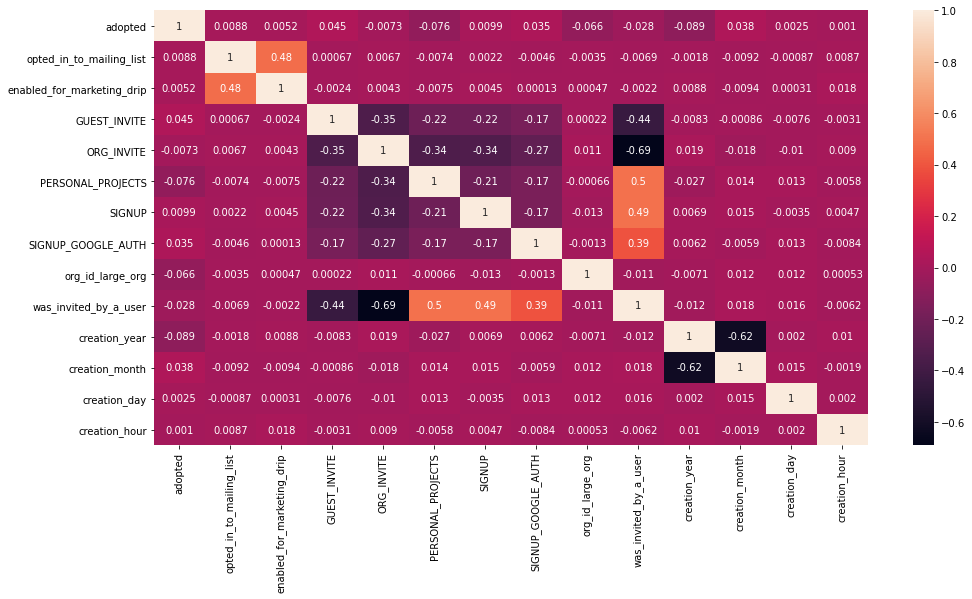

In [67]:
plt.figure(figsize=(16,8))
sns.heatmap(pd.concat([y,X], axis=1).corr('spearman'), annot=True)

### <a id='preprocessing'></a> Preprocessing
[(Back to top)](#TOC)

In [82]:
# Need to drop this dummy column to avoid co-linearity
# Also should drop creation time columns that seem useless based on exploratory analysis
X = X.drop(['SIGNUP_GOOGLE_AUTH','creation_month','creation_day','creation_hour'], axis=1)  

In [83]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   opted_in_to_mailing_list    12000 non-null  int64
 1   enabled_for_marketing_drip  12000 non-null  int64
 2   GUEST_INVITE                12000 non-null  uint8
 3   ORG_INVITE                  12000 non-null  uint8
 4   PERSONAL_PROJECTS           12000 non-null  uint8
 5   SIGNUP                      12000 non-null  uint8
 6   org_id_large_org            12000 non-null  int32
 7   was_invited_by_a_user       12000 non-null  bool 
 8   creation_year               12000 non-null  int64
dtypes: bool(1), int32(1), int64(3), uint8(4)
memory usage: 738.5 KB


In [84]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   adopted  12000 non-null  bool 
dtypes: bool(1)
memory usage: 363.5 KB


### <a id='modeling'></a> Modeling
[(Back to top)](#TOC)

I will primarily use decision tree methods. This dataset is not friendly for continuous parametric analysis. Too many dummy variables.

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [86]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix



RandomForest
gs.best_params_ {'n_estimators': 500}
gs.best_score_ 0.594569688139426
{'mean_fit_time': array([0.08120604, 0.15901136, 0.29262447, 0.59524431, 1.40070467]), 'std_fit_time': array([0.00375778, 0.00864948, 0.01820222, 0.04150261, 0.01380839]), 'mean_score_time': array([0.01040072, 0.01820326, 0.03100371, 0.05560455, 0.13560729]), 'std_score_time': array([0.00049021, 0.00147013, 0.00352042, 0.00149818, 0.00775876]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.60324795, 0.59410234, 0.59566272, 0.59606077, 0.59795678]), 'split1_test_score': array([0.59324501, 0.59386445, 0.59490785, 0.59607608, 0.59535064]), 'split2_test_score': array([0.59199641, 0.59239784, 0.59078275, 0.59519137, 0.59413734]), 's

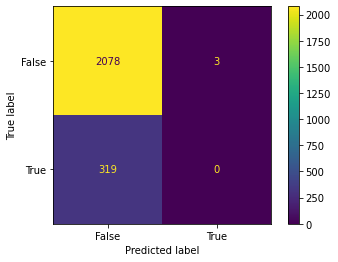

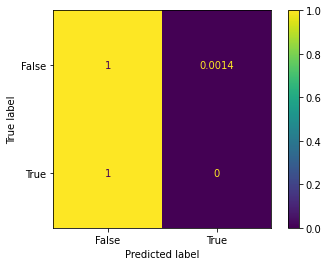

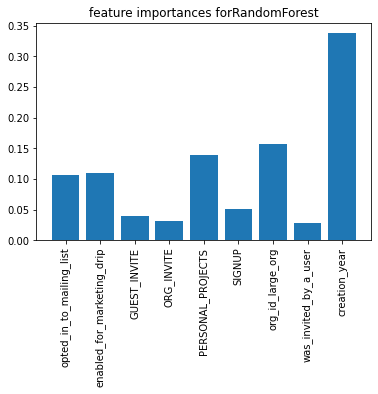



ExtraTrees
gs.best_params_ {'n_estimators': 25}
gs.best_score_ 0.594934626391119
{'mean_fit_time': array([0.08120561, 0.1462101 , 0.27642293, 0.56190023, 1.52838459]), 'std_fit_time': array([0.00475108, 0.00159658, 0.00332367, 0.01107998, 0.08553544]), 'mean_score_time': array([0.01060166, 0.01780243, 0.02940226, 0.05700397, 0.1526155 ]), 'std_score_time': array([0.00080027, 0.0011676 , 0.00079942, 0.00244904, 0.01338001]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.59811576, 0.59811576, 0.59811576, 0.59811576, 0.59811576]), 'split1_test_score': array([0.59610669, 0.59610669, 0.59610669, 0.59610669, 0.59610669]), 'split2_test_score': array([0.59514559, 0.59514559, 0.59514559, 0.59514559, 0.59514559]), 'spli

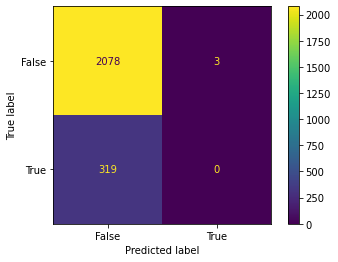

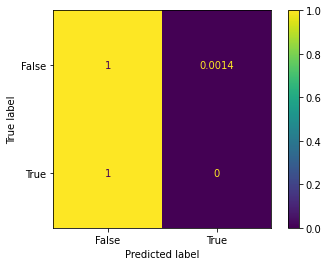

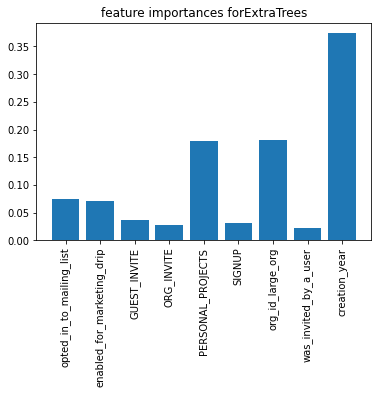



GradientBoosting
gs.best_params_ {'n_estimators': 25}
gs.best_score_ 0.6176807256613451
{'mean_fit_time': array([0.09940715, 0.18521385, 0.37628417, 0.6681663 , 1.57511873]), 'std_fit_time': array([0.00294032, 0.0112852 , 0.03109066, 0.04308259, 0.02597887]), 'mean_score_time': array([0.00580034, 0.00680027, 0.00840058, 0.01139941, 0.02020144]), 'std_score_time': array([0.00074842, 0.00116779, 0.00079911, 0.00102057, 0.00039959]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.61394924, 0.61062945, 0.61263381, 0.61676264, 0.61244068]), 'split1_test_score': array([0.63199199, 0.6236778 , 0.62041689, 0.61575105, 0.61246776]), 'split2_test_score': array([0.61378596, 0.61018137, 0.60730333, 0.6086015 , 0.60615774])

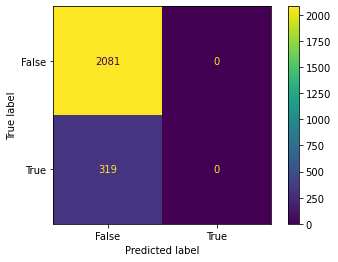

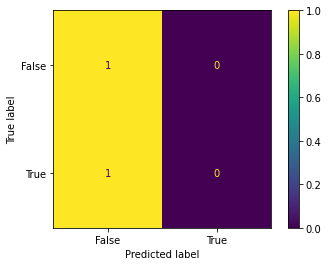

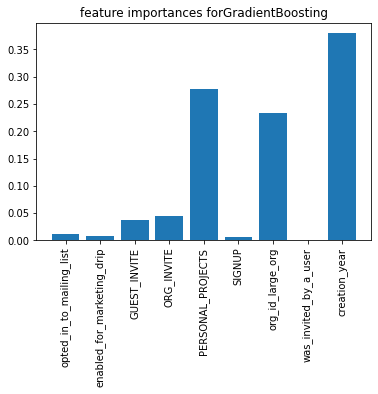

In [88]:
params_rf = {'n_estimators':[25,50,100,200,500]}
params_et = {'n_estimators':[25,50,100,200,500]}
params_gb = {'n_estimators':[25,50,100,200,500]}

for est, params, name in zip([RandomForestClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier()],
                             [params_rf, params_et, params_gb],
                             ["RandomForest", "ExtraTrees", "GradientBoosting"]):
    gs = GridSearchCV(est, params, cv=5, scoring='roc_auc')
    gs.fit(X_train, y_train.values.ravel())
    print('\n')
    print(name)
    print("gs.best_params_",gs.best_params_)
    print("gs.best_score_",gs.best_score_)
    print(gs.cv_results_)
    print('\n')
    
    gs.best_estimator_.fit(X_train, y_train.values.ravel())
    print(name)
    predictions = gs.best_estimator_.predict(X_test)
    print('accuracy:', np.mean(predictions==y_test.values.ravel()))
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test.values.ravel())
    plt.show()
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test.values.ravel(), normalize='true')
    plt.show()
    print('\n')
    
    plt.bar(x=X.columns, height=gs.best_estimator_.feature_importances_)
    plt.xticks(rotation=90)
    plt.title('feature importances for'+ name)
    plt.show()



RandomForest
gs.best_params_ {'n_estimators': 200}
gs.best_score_ 0.5953448060628236
{'mean_fit_time': array([0.07260461, 0.15121107, 0.30022488, 0.58184628, 1.46370974]), 'std_fit_time': array([0.00492193, 0.00749385, 0.0157004 , 0.02839236, 0.11805091]), 'mean_score_time': array([0.00880017, 0.01580162, 0.02859912, 0.05340171, 0.1352129 ]), 'std_score_time': array([0.00171971, 0.00116662, 0.00233475, 0.00119882, 0.0094938 ]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.59276335, 0.59674734, 0.59823117, 0.59873403, 0.59761762]), 'split1_test_score': array([0.59601013, 0.59466996, 0.59445563, 0.59523995, 0.59653536]), 'split2_test_score': array([0.59185322, 0.59521954, 0.59565852, 0.59565617, 0.5959637 ]), '

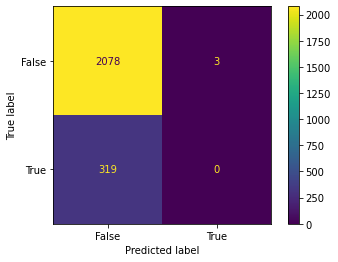

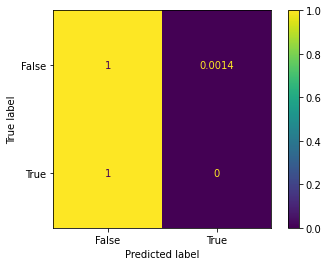

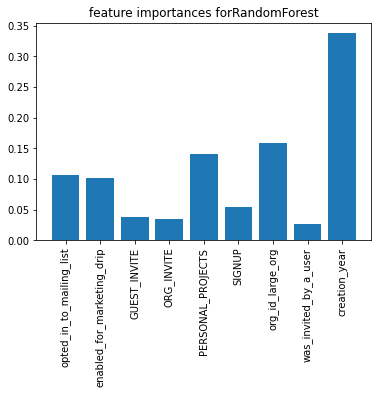



ExtraTrees
gs.best_params_ {'n_estimators': 50}
gs.best_score_ 0.5950407336627538
{'mean_fit_time': array([0.07980647, 0.14441004, 0.31922231, 0.58204994, 1.46755118]), 'std_fit_time': array([0.00584594, 0.00578019, 0.03849917, 0.02456711, 0.0390731 ]), 'mean_score_time': array([0.00920057, 0.0160027 , 0.02780271, 0.05320115, 0.1354125 ]), 'std_score_time': array([0.00193826, 0.00154831, 0.00172034, 0.00171549, 0.00902195]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.59811576, 0.59811576, 0.59811576, 0.59811576, 0.59811576]), 'split1_test_score': array([0.59610669, 0.59610669, 0.59610669, 0.59610669, 0.59610669]), 'split2_test_score': array([0.59514559, 0.59514559, 0.59514559, 0.59514559, 0.59514559]), 'spl

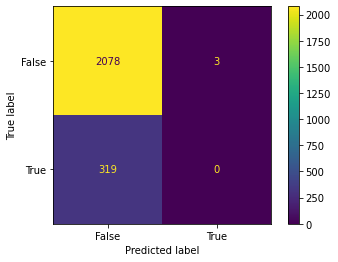

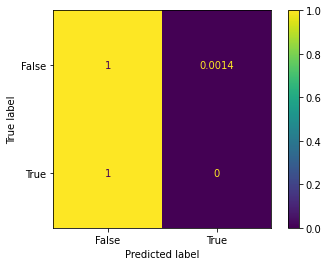

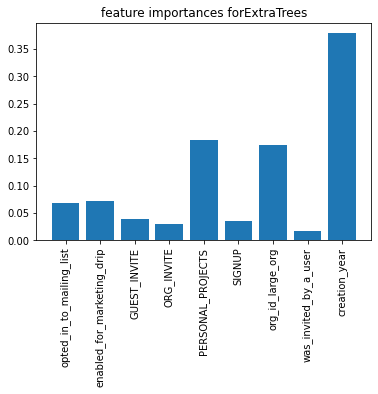



GradientBoosting
gs.best_params_ {'n_estimators': 25}
gs.best_score_ 0.6176807256613451
{'mean_fit_time': array([0.08580618, 0.16641145, 0.32742362, 0.63684764, 1.60171919]), 'std_fit_time': array([0.0060141 , 0.01038544, 0.01338099, 0.01988346, 0.0233641 ]), 'mean_score_time': array([0.00259995, 0.00340095, 0.00540133, 0.00880075, 0.01780195]), 'std_score_time': array([0.00048978, 0.00049045, 0.00049012, 0.00040067, 0.00040016]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.61394924, 0.61062945, 0.61263381, 0.61676264, 0.61244068]), 'split1_test_score': array([0.63199199, 0.6236778 , 0.62041689, 0.61575105, 0.61246776]), 'split2_test_score': array([0.61378596, 0.61018137, 0.60730333, 0.6086015 , 0.60615774])

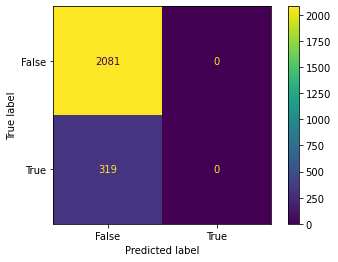

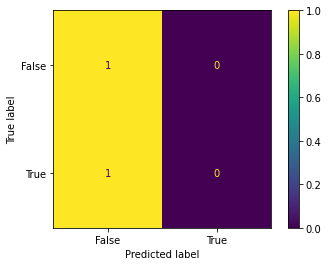

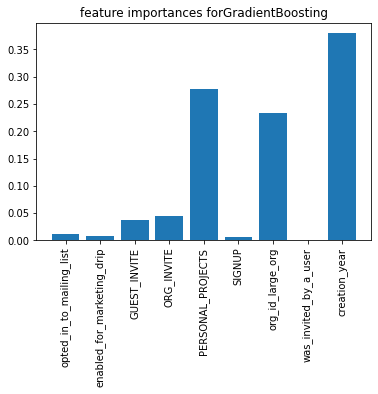

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

params_rf = {'n_estimators':[25,50,100,200,500]}
params_et = {'n_estimators':[25,50,100,200,500]}
params_gb = {'n_estimators':[25,50,100,200,500]}

for est, params, name in zip([RandomForestClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier()],
                             [params_rf, params_et, params_gb],
                             ["RandomForest", "ExtraTrees", "GradientBoosting"]):
    gs = GridSearchCV(est, params, cv=5, scoring='roc_auc')
    gs.fit(X_train, y_train.values.ravel())
    print('\n')
    print(name)
    print("gs.best_params_",gs.best_params_)
    print("gs.best_score_",gs.best_score_)
    print(gs.cv_results_)
    print('\n')
    
    gs.best_estimator_.fit(X_train, y_train.values.ravel())
    print(name)
    predictions = gs.best_estimator_.predict(X_test)
    print('accuracy:', np.mean(predictions==y_test.values.ravel()))
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test.values.ravel())
    plt.show()
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test.values.ravel(), normalize='true')
    plt.show()
    print('\n')
    
    plt.bar(x=X.columns, height=gs.best_estimator_.feature_importances_)
    plt.xticks(rotation=90)
    plt.title('feature importances for'+ name)
    plt.show()

# This is problematic. Every model is predicting only non-adoption. I will try oversampling the adopting users to compensate.

In [101]:
X_adopted_10000 = X.loc[np.random.choice(y.loc[y.adopted==True].index, size=10000),:]
X_notadopted_10000 = X.loc[np.random.choice(y.loc[y.adopted==False].index, size=10000),:]

X_sampled = pd.concat([X_adopted_10000, X_notadopted_10000], axis=0)
y_sampled = np.append(np.ones(10000), np.zeros(10000))

print(X_sampled.info())
print(y_sampled.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 11975 to 9628
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   opted_in_to_mailing_list    20000 non-null  int64
 1   enabled_for_marketing_drip  20000 non-null  int64
 2   GUEST_INVITE                20000 non-null  uint8
 3   ORG_INVITE                  20000 non-null  uint8
 4   PERSONAL_PROJECTS           20000 non-null  uint8
 5   SIGNUP                      20000 non-null  uint8
 6   org_id_large_org            20000 non-null  int32
 7   was_invited_by_a_user       20000 non-null  bool 
 8   creation_year               20000 non-null  int64
dtypes: bool(1), int32(1), int64(3), uint8(4)
memory usage: 800.8 KB
None
(20000,)




RandomForest
gs.best_params_ {'n_estimators': 50}
gs.best_score_ 0.631878828125
{'mean_fit_time': array([0.11200919, 0.21521497, 0.4182312 , 0.83805842, 2.09695787]), 'std_fit_time': array([0.01104623, 0.005154  , 0.00730594, 0.02735866, 0.04175654]), 'mean_score_time': array([0.0125999 , 0.0204021 , 0.04040427, 0.07360868, 0.18441615]), 'std_score_time': array([0.00120054, 0.00049006, 0.00287122, 0.00119769, 0.00752421]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.64580879, 0.64732324, 0.64616777, 0.64690566, 0.64580996]), 'split1_test_score': array([0.62562402, 0.62600566, 0.62493145, 0.62480957, 0.62538145]), 'split2_test_score': array([0.63780918, 0.6383873 , 0.63883926, 0.63796582, 0.63797754]), 'split

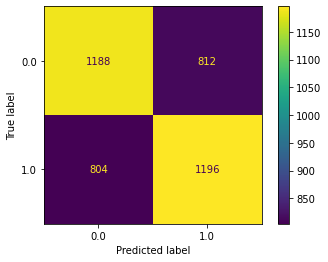

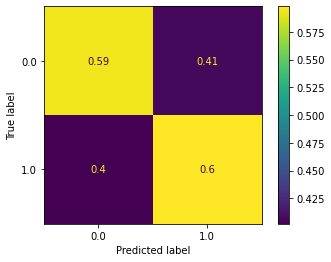

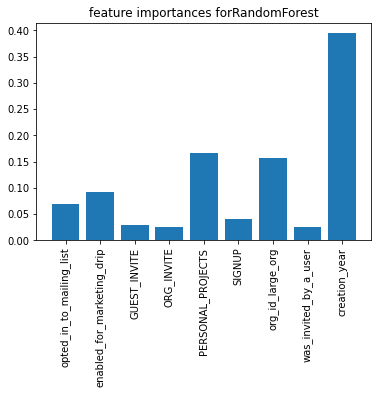



ExtraTrees
gs.best_params_ {'n_estimators': 25}
gs.best_score_ 0.6316677734374999
{'mean_fit_time': array([0.11233263, 0.21261559, 0.44963355, 0.88566675, 2.16200771]), 'std_fit_time': array([0.0044973 , 0.00595293, 0.01866416, 0.03235387, 0.05134469]), 'mean_score_time': array([0.01200142, 0.02040172, 0.04000406, 0.08060646, 0.1816112 ]), 'std_score_time': array([0.00063249, 0.0004892 , 0.00275725, 0.00535276, 0.00287257]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.64672793, 0.64672793, 0.64672793, 0.64672793, 0.64672793]), 'split1_test_score': array([0.62505781, 0.62505781, 0.62505781, 0.62505781, 0.62505781]), 'split2_test_score': array([0.63813809, 0.63813809, 0.63813809, 0.63813809, 0.63813809]), 'spl

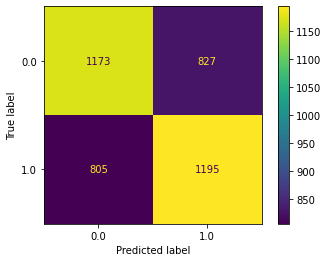

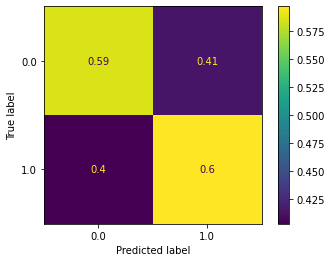

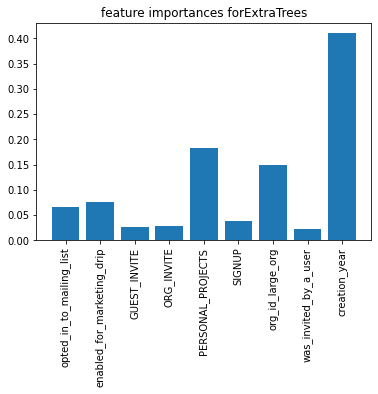



GradientBoosting
gs.best_params_ {'n_estimators': 200}
gs.best_score_ 0.627183125
{'mean_fit_time': array([0.13020973, 0.27021885, 0.51103916, 1.00578356, 2.50498967]), 'std_fit_time': array([0.00591283, 0.0122855 , 0.02039825, 0.01268601, 0.03373699]), 'mean_score_time': array([0.00379992, 0.00480008, 0.00859995, 0.01420112, 0.03000007]), 'std_score_time': array([0.00116581, 0.00040066, 0.00119998, 0.00147046, 0.00126038]), 'param_n_estimators': masked_array(data=[25, 50, 100, 200, 500],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 25}, {'n_estimators': 50}, {'n_estimators': 100}, {'n_estimators': 200}, {'n_estimators': 500}], 'split0_test_score': array([0.6339332 , 0.63855781, 0.6408584 , 0.64070449, 0.63922637]), 'split1_test_score': array([0.61587129, 0.61897754, 0.61815645, 0.6213709 , 0.62088691]), 'split2_test_score': array([0.63141484, 0.63406152, 0.63351504, 0.6335959 , 0.63245645]), 'spl

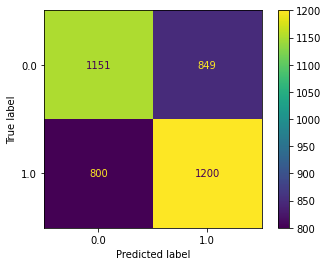

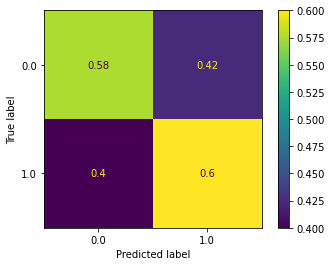

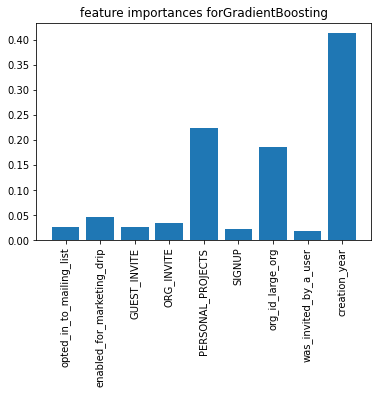

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

params_rf = {'n_estimators':[25,50,100,200,500]}
params_et = {'n_estimators':[25,50,100,200,500]}
params_gb = {'n_estimators':[25,50,100,200,500]}

for est, params, name in zip([RandomForestClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier()],
                             [params_rf, params_et, params_gb],
                             ["RandomForest", "ExtraTrees", "GradientBoosting"]):
    gs = GridSearchCV(est, params, cv=5, scoring='roc_auc')
    gs.fit(X_train, y_train)
    print('\n')
    print(name)
    print("gs.best_params_",gs.best_params_)
    print("gs.best_score_",gs.best_score_)
    print(gs.cv_results_)
    print('\n')
    
    gs.best_estimator_.fit(X_train, y_train)
    print(name)
    predictions = gs.best_estimator_.predict(X_test)
    print('accuracy:', np.mean(predictions==y_test))
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test)
    plt.show()
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test, normalize='true')
    plt.show()
    print('\n')
    
    plt.bar(x=X.columns, height=gs.best_estimator_.feature_importances_)
    plt.xticks(rotation=90)
    plt.title('feature importances for'+ name)
    plt.show()



RandomForest
gs.best_params_ {'bootstrap': True, 'max_depth': 8, 'max_samples': 0.85, 'n_estimators': 50}
gs.best_score_ 0.6320917187499999
{'mean_fit_time': array([0.07460666, 0.15801268, 0.22621665, 0.31162314, 0.07460656,
       0.15481153, 0.22821541, 0.31242323, 0.08280511, 0.164012  ,
       0.22381763, 0.31902342, 0.08060713, 0.15841107, 0.24041815,
       0.32642498, 0.08680615, 0.16361213, 0.24461727, 0.32022758,
       0.05240488, 0.09760804, 0.13661065, 0.19761558, 0.09140739,
       0.17341304, 0.26081839, 0.33062396, 0.0932065 , 0.1770133 ,
       0.25781865, 0.32982469, 0.0858088 , 0.17980928, 0.25961905,
       0.36222672, 0.08720584, 0.17161222, 0.26161938, 0.34442501,
       0.09220734, 0.18461399, 0.27601905, 0.36902752, 0.05220442,
       0.09620605, 0.16021309, 0.19681578, 0.09960737, 0.20241523,
       0.29842148, 0.39962931, 0.10700765, 0.19481435, 0.27742081,
       0.39562745, 0.10680723, 0.21161685, 0.31562428, 0.42423239,
       0.10680747, 0.21301579, 0.317

RandomForest
accuracy: 0.5905


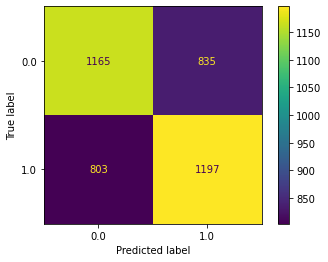

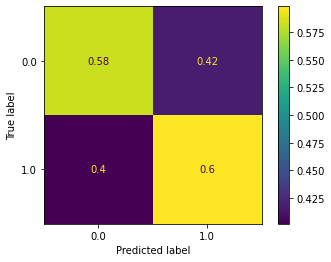

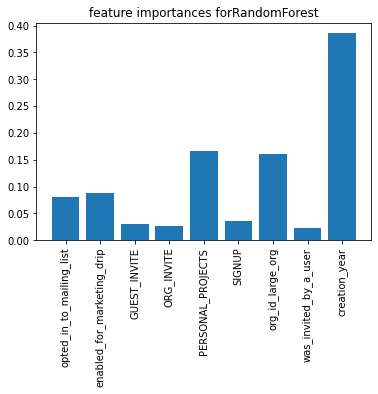



ExtraTrees
gs.best_params_ {'bootstrap': True, 'max_depth': None, 'max_samples': 0.9, 'n_estimators': 25}
gs.best_score_ 0.632143359375
{'mean_fit_time': array([0.08080506, 0.14401574, 0.21901326, 0.28942175, 0.07920547,
       0.15501204, 0.2346168 , 0.29842196, 0.07960577, 0.15321078,
       0.2346169 , 0.32402492, 0.07940626, 0.16181216, 0.24181809,
       0.31682467, 0.08060493, 0.15441165, 0.23161759, 0.2960248 ,
       0.04760141, 0.09040236, 0.13561053, 0.18941483, 0.07920599,
       0.16181273, 0.24841824, 0.33442545, 0.09100728, 0.17621207,
       0.26061988, 0.3256269 , 0.08620629, 0.17701402, 0.26281929,
       0.33402529, 0.08440585, 0.16941247, 0.25981979, 0.35382767,
       0.08480549, 0.16240921, 0.24622207, 0.33382545, 0.05100298,
       0.09760752, 0.14161367, 0.18061461, 0.08720789, 0.17001338,
       0.26981831, 0.36043124, 0.09021029, 0.18241076, 0.27902093,
       0.37442813, 0.11180949, 0.1942142 , 0.28442063, 0.38062792,
       0.09340682, 0.20121465, 0.2834241

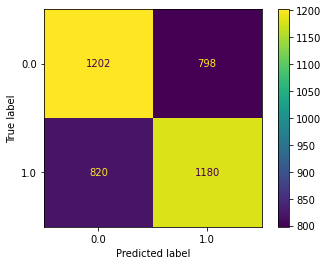

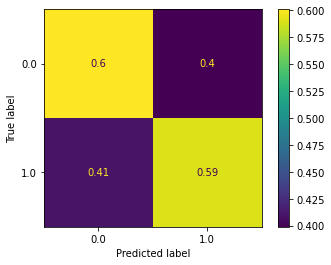

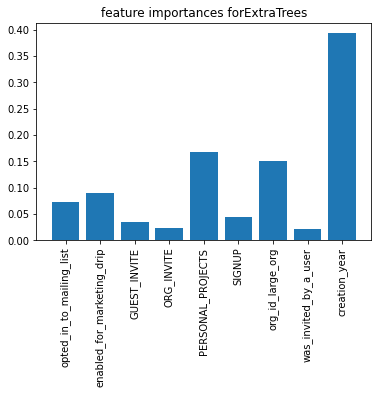



GradientBoosting
gs.best_params_ {'loss': 'deviance', 'n_estimators': 100, 'subsample': 0.7}
gs.best_score_ 0.6273378906249999
{'mean_fit_time': array([0.12620974, 0.12920995, 0.13735814, 0.13141041, 0.12661076,
       0.24861894, 0.25661979, 0.25501971, 0.25801954, 0.24761972,
       0.38502927, 0.38482862, 0.39062943, 0.38223181, 0.36122298,
       0.5028379 , 0.50463829, 0.51783862, 0.52103925, 0.49943738,
       0.13141055, 0.13681183, 0.13441029, 0.13660998, 0.13120899,
       0.25442038, 0.26501937, 0.27222023, 0.27102041, 0.25781946,
       0.40223036, 0.39822803, 0.39342914, 0.39503245, 0.39942646,
       0.53083968, 0.53964095, 0.5380403 , 0.54964118, 0.50143533]), 'std_fit_time': array([0.00487437, 0.00793659, 0.01381957, 0.00205893, 0.00392994,
       0.00484136, 0.01089289, 0.00562186, 0.00619705, 0.00491386,
       0.00712778, 0.00963793, 0.00831412, 0.00365508, 0.0023115 ,
       0.01006868, 0.01151701, 0.01465684, 0.00771775, 0.01991757,
       0.00185399, 0.00430597, 

GradientBoosting
accuracy: 0.59075


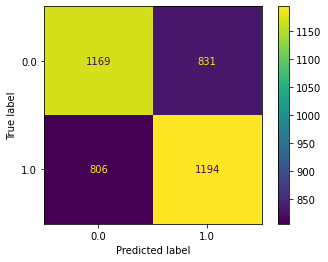

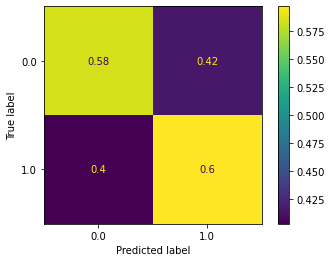

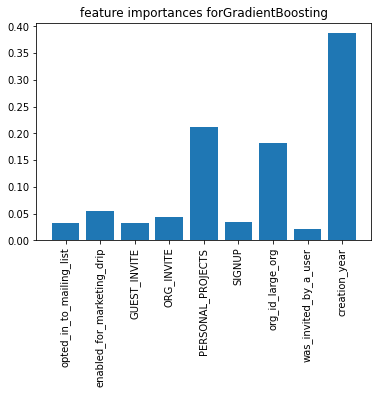

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

params_rf = {'n_estimators':[25,50,75,100], 'max_samples':[0.7, 0.75, 0.8, 0.85, 0.9, 1], 'bootstrap':[True], 'max_depth':[3,5,8,None]}   # 
params_et = {'n_estimators':[25,50,75,100], 'max_samples':[0.7, 0.75, 0.8, 0.85, 0.9, 1], 'bootstrap':[True], 'max_depth':[3,5,8,None]}  #, 'max_depth':[3,5,8,None]
params_gb = {'n_estimators':[25,50,75,100], 'subsample':[0.7, 0.75, 0.8, 0.85, 1], 'loss':['exponential', 'deviance']}

for est, params, name in zip([RandomForestClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier()],
                             [params_rf, params_et, params_gb],
                             ["RandomForest", "ExtraTrees", "GradientBoosting"]):
    gs = GridSearchCV(est, params, cv=5, scoring='roc_auc')
    gs.fit(X_train, y_train)
    print('\n')
    print(name)
    print("gs.best_params_",gs.best_params_)
    print("gs.best_score_",gs.best_score_)
    print(gs.cv_results_)
    print('\n')
    
    gs.best_estimator_.fit(X_train, y_train)
    print(name)
    predictions = gs.best_estimator_.predict(X_test)
    print('accuracy:', np.mean(predictions==y_test))
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test)
    plt.show()
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test, normalize='true')
    plt.show()
    print('\n')
    
    plt.bar(x=X.columns, height=gs.best_estimator_.feature_importances_)
    plt.xticks(rotation=90)
    plt.title('feature importances for'+ name)
    plt.show()



RandomForest
gs.best_params_ {'bootstrap': True, 'max_depth': 8, 'max_samples': 0.9, 'n_estimators': 50}
gs.best_score_ 0.6318965625
{'mean_fit_time': array([0.20761518, 0.20341511, 0.21181588, 0.21221576, 0.21441512,
       0.1034071 , 0.21441526, 0.22101688, 0.21021633, 0.22101631,
       0.22661772, 0.10340805]), 'std_fit_time': array([0.0110392 , 0.00806716, 0.01053449, 0.01123263, 0.00717296,
       0.00801589, 0.00366816, 0.01234784, 0.01050711, 0.00998021,
       0.00653106, 0.00682986]), 'mean_score_time': array([0.02060184, 0.02360158, 0.0228014 , 0.02100158, 0.02120271,
       0.01180124, 0.02360258, 0.02100101, 0.02040119, 0.02200227,
       0.02120085, 0.01219983]), 'std_score_time': array([0.00080066, 0.00272782, 0.00470682, 0.001673  , 0.00159998,
       0.00074795, 0.00484388, 0.00063241, 0.00048924, 0.00209892,
       0.00039806, 0.00147063]), 'param_bootstrap': masked_array(data=[True, True, True, True, True, True, True, True, True,
                   True, True, Tru

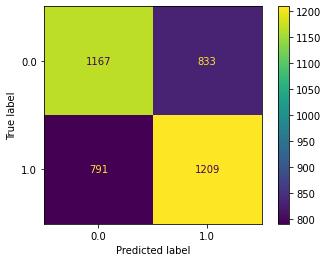

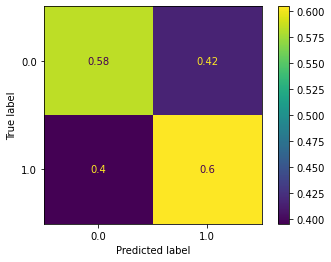

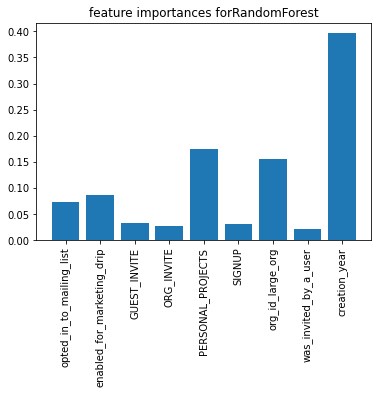



ExtraTrees
gs.best_params_ {'bootstrap': True, 'max_depth': None, 'max_samples': 0.85, 'n_estimators': 25}
gs.best_score_ 0.6322093750000001
{'mean_fit_time': array([0.09580669, 0.19781132, 0.11140924, 0.19281397, 0.09840755,
       0.19061375, 0.09640632, 0.19401813, 0.1000042 , 0.19701486,
       0.10040488, 0.20281506, 0.05000291, 0.09900632, 0.10640836,
       0.19361405, 0.10920753, 0.21081605, 0.10120821, 0.19561529,
       0.09900775, 0.19381728, 0.09560728, 0.20281606, 0.10400748,
       0.21581626, 0.05280466, 0.09840717]), 'std_fit_time': array([0.00495502, 0.00828502, 0.01839271, 0.00617726, 0.00392958,
       0.00300646, 0.00185427, 0.00394734, 0.00493482, 0.00697527,
       0.00205598, 0.00837691, 0.001896  , 0.00296577, 0.0064076 ,
       0.00500406, 0.00407038, 0.00699816, 0.00365547, 0.00162467,
       0.0026852 , 0.00203592, 0.00162408, 0.00738763, 0.00536699,
       0.01511952, 0.00193932, 0.00120079]), 'mean_score_time': array([0.01140413, 0.02060142, 0.01339927, 0

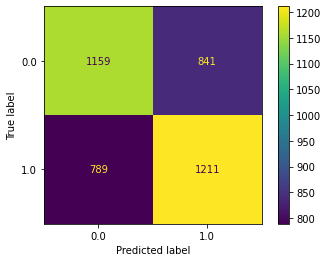

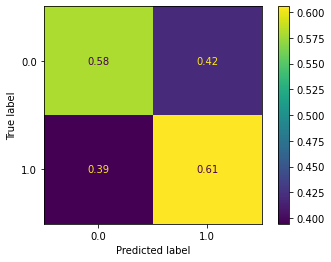

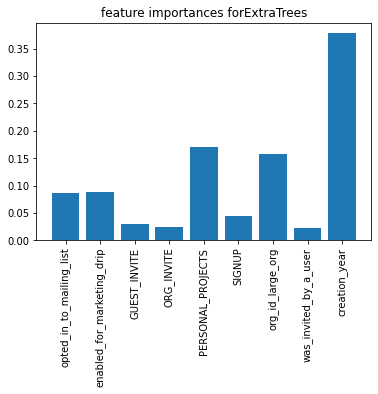



GradientBoosting
gs.best_params_ {'loss': 'deviance', 'n_estimators': 300, 'subsample': 0.6}
gs.best_score_ 0.6278489062500001
{'mean_fit_time': array([0.47823563, 0.49703751, 0.48881392, 0.50503774, 0.50563831,
       0.95048747, 0.92206917, 0.96927319, 0.9743525 , 0.94627132,
       1.40990353, 1.45838232, 1.45750952, 1.52351437, 1.45231013,
       0.49283657, 0.50744104, 0.5116354 , 0.52363925, 0.50963941,
       1.01415439, 1.00108609, 1.02687817, 1.04447818, 0.98807392,
       1.51771774, 1.52550983, 1.5411211 , 1.60911808, 1.58181124]), 'std_fit_time': array([0.01510754, 0.01484706, 0.00771907, 0.0155833 , 0.01883367,
       0.00173145, 0.01370864, 0.02773342, 0.02208654, 0.02815436,
       0.04753788, 0.03334489, 0.02001486, 0.0232358 , 0.03345209,
       0.0071955 , 0.00989627, 0.01173544, 0.00923587, 0.0114829 ,
       0.01357128, 0.02953065, 0.06020663, 0.01289451, 0.01785718,
       0.03703967, 0.00897449, 0.0222891 , 0.07437422, 0.0625442 ]), 'mean_score_time': array([0.0

GradientBoosting
accuracy: 0.5865


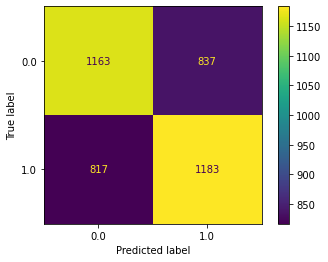

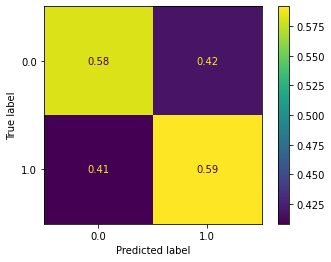

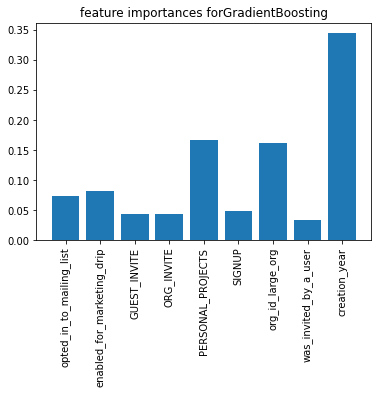

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42, stratify=y_sampled)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

params_rf = {'n_estimators':[50], 'max_samples':[0.8, 0.825, 0.85, 0.875, 0.9, 1], 'bootstrap':[True], 'max_depth':[8,None]}   # 
params_et = {'n_estimators':[25,50], 'max_samples':[0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1], 'bootstrap':[True], 'max_depth':[8,None]}  #, 'max_depth':[3,5,8,None]
params_gb = {'n_estimators':[100, 200, 300], 'subsample':[0.6, 0.65, 0.7, 0.75, 1], 'loss':['exponential', 'deviance']}

for est, params, name in zip([RandomForestClassifier(), ExtraTreesClassifier(), GradientBoostingClassifier()],
                             [params_rf, params_et, params_gb],
                             ["RandomForest", "ExtraTrees", "GradientBoosting"]):
    gs = GridSearchCV(est, params, cv=5, scoring='roc_auc')
    gs.fit(X_train, y_train)
    print('\n')
    print(name)
    print("gs.best_params_",gs.best_params_)
    print("gs.best_score_",gs.best_score_)
    print(gs.cv_results_)
    print('\n')
    
    gs.best_estimator_.fit(X_train, y_train)
    print(name)
    predictions = gs.best_estimator_.predict(X_test)
    print('accuracy:', np.mean(predictions==y_test))
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test)
    plt.show()
    plot_confusion_matrix(gs.best_estimator_, X_test, y_test, normalize='true')
    plt.show()
    print('\n')
    
    plt.bar(x=X.columns, height=gs.best_estimator_.feature_importances_)
    plt.xticks(rotation=90)
    plt.title('feature importances for'+ name)
    plt.show()

### <a id='metrics'></a> Model Metrics
[(Back to top)](#TOC)

| Model  | Best parameters  | Best CV ROC_AUC  | Best Test Accuracy  |
|---|---|---|---|
| ExtraTreesClassifier  | n_estimators=25, max_depth=None, bootstrap=True, max_samples=0.85  | 0.6322  | 0.5925  |
| RandomForestClassifier  | n_estimators=50, max_depth=8, bootstrap=True, max_samples=0.85  | 0.6321  | 0.5905  |
| GradientBoostingClassifier  | n_estimators=300, subsample=0.6, loss='deviance'  |  0.6279  |  0.5865  |

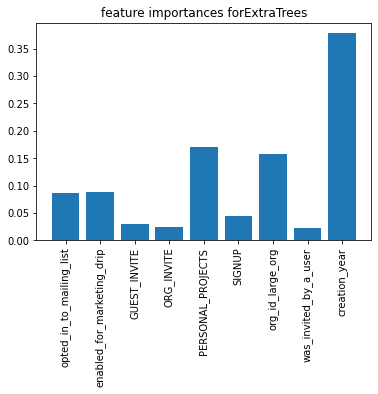

### <a id='recommendations'></a> Recommendations
[(Back to top)](#TOC)

# It seems the best model is a ExtraTreesClassifier with 25 estimators and bootstrapping max_samples of 0.85.

Creation year is the most important feature. Users with a longer history are more likely to have adopted the product.

Next most important is whether users signed up for PERSONAL_PROJECTS or if the org they come from has many other users. Both these conditions are associated with less likelihood to have adopted the project.

Finally, enabled_for_marketing_drip and opted_in_to_mailing_list are positive predictors and adoption.

It must be noted that these models do not perform very well. The accuracy for each class (adopters and non-adopters) was only about 60%. It appears that adoption is not easy to predict based on the available data.